In [1]:
clear

## Caricamento Dati

La seguente funzione permette di caricare matrici sparse, provenienti dal sito [https://sparse.tamu.edu/](https://sparse.tamu.edu/), salvate su file nel formato matlab.<br>
Questa funzione riesce a gestire sia i vecchi formati (`< matlab v7.3`) che quelli nuovi.

In [2]:
function A = loadFunctionFromData(dataPath)
    disp(["🦍 Loading file: "  dataPath])
    load(dataPath)
    
%   se nel file è presente una `struct` allora vuol dire 
%   che sto utilizzando il nuovo formato e va convertito
%   per essere utilizzato da Octave
    if isstruct(Problem.A)
        n = length(Problem.A.jc)-1;
        ii = repelems(1:n, [1:n; diff(Problem.A.jc)]);
        A = sparse(Problem.A.ir+1, ii, Problem.A.data);
    else
        A = Problem.A;
    end
endfunction

In [3]:
% Esempio di come utilizzare la precedente funzione
% whos
% A = loadFunctionFromData('./data/cage15.mat');
% columns(A)
% rows(A)
% clear
% A = loadFunctionFromData('./data/vas_stokes_2M.mat');
% columns(A)
% rows(A)

La seguente funzione genera i dati iniziali per poter utilizzare GMRES.

In [4]:
function [A b x0] = generateData(dim, den, seed=69, randx0=false)
    rand("seed", seed);
    A = sprand(dim, dim, den);
    b = rand(dim, 1);
    
    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

GMRES function

In [239]:
function [x res] = caagmres(A, b, x0, k, tol)
    n = size(b)(1);
    Q = zeros(n, k+1);
    H = zeros(k+2, k+1);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    Q(:, 1) = r0/norm(r0, 2);
%     ress = [];
%     e1 = zeros(n, 1);
%     e1(1) = 1;
%     e1 = e1';
    for j = 1:k  %% TODO: ricontrollare
        imagesc(H);
        
        v = A*Q(:, j);        
        for i = 1:j
            H(i,j) = Q(:,i)' * v;
            v = v - H(i, j) * Q(:, i);
        end
        
        H(j+1, j) = norm(v, 2);
        Q(:, j+1) = v / H(j+1, j);
        
%         if (abs(H(j+1, j)) > tol)
%             Q(:, j+1) = Q(:,j+1)/H(j+1,j);
%         end
        
        e1 = zeros(j+2, 1);
        e1(1) = 1;
        
%         y =(H(:, j))\(beta *e1);
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res(j) = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);

        if (res(j) < tol)
            disp('Raggiunta toll');
            x = Q(:, 1:j+1)*y +x0;
            return;
        end
    end
    x = Q(:, 1:j+1)*y +x0;
endfunction

In [240]:
[A, b, x0] = generateData(20, .5);

In [241]:
A
b
x0

A =

Compressed Column Sparse (rows = 20, cols = 20, nnz = 200 [50%])

  (1, 1) ->  0.97905
  (2, 1) ->  0.59846
  (7, 1) ->  0.33995
  (8, 1) ->  0.95621
  (9, 1) ->  0.40265
  (10, 1) ->  0.62846
  (11, 1) ->  0.20515
  (14, 1) ->  0.17364
  (18, 1) ->  0.78380
  (20, 1) ->  0.85015
  (1, 2) ->  0.40426
  (3, 2) ->  0.99505
  (4, 2) ->  0.66023
  (5, 2) ->  0.79189
  (6, 2) ->  0.37604
  (7, 2) ->  0.97922
  (9, 2) ->  0.65213
  (11, 2) ->  0.14187
  (12, 2) ->  0.74548
  (13, 2) ->  0.74811
  (15, 2) ->  0.37764
  (20, 2) ->  0.70329
  (4, 3) ->  0.20859
  (10, 3) ->  0.39284
  (11, 3) ->  0.48878
  (13, 3) ->  0.88121
  (14, 3) ->  0.73117
  (16, 3) ->  0.34027
  (20, 3) ->  0.95351
  (3, 4) ->  0.17261
  (4, 4) ->  0.27808
  (5, 4) ->  0.039353
  (7, 4) ->  0.068567
  (8, 4) ->  0.088888
  (11, 4) ->  0.93467
  (12, 4) ->  0.78162
  (17, 4) ->  0.68566
  (2, 5) ->  0.057886
  (3, 5) ->  0.042369
  (4, 5) ->  0.12403
  (6, 5) ->  0.20682
  (7, 5) ->  0.12625
  (9, 5) ->  0.12161
  

Raggiunta toll


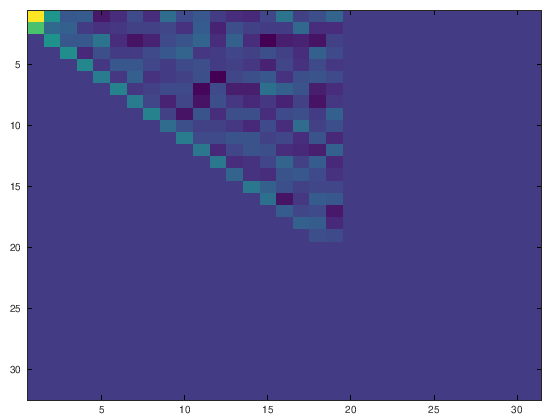

In [242]:
[x, res] = caagmres(A, b, x0, 30, 1e-10);

In [243]:
x
trueres = A\b
max(trueres-x)

x =

  -0.527521
   0.352300
  -1.389698
   0.306033
  -6.176804
  -0.290322
   4.367626
  -0.972639
   1.929987
  -2.680901
   2.546768
   0.021386
   0.200280
   4.798034
   0.365567
  -5.430610
   1.106888
  -0.094631
   1.935941
  -0.964871

trueres =

  -0.527521
   0.352300
  -1.389698
   0.306033
  -6.176804
  -0.290322
   4.367626
  -0.972639
   1.929987
  -2.680901
   2.546768
   0.021386
   0.200280
   4.798034
   0.365567
  -5.430610
   1.106888
  -0.094631
   1.935941
  -0.964871

ans =    1.5010e-13


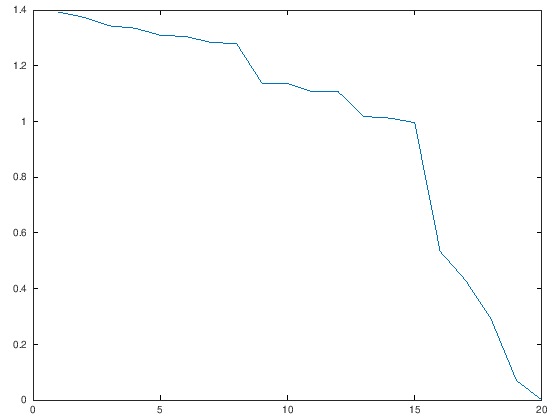

In [244]:
plot(res);

In [97]:
function [Q, H, breakdown] = ANROLDI(A, b,Qold, Hold, n, tol)
    Hold
    if any(Hold) || isempty(Hold)
        H = [0 0]'
    else
%         H = [Hold 0;
%              0 0];
        H = [Hold zeros(size(Hold, 1), 1);
            zeros(1, size(Hold, 2) + 1)];
    end
    
    Q = [Qold  zeros(size(Qold, 1), 1)];
%     Qold
    w = A * Q(:, n);
    
    for i = max(1, n-1):n
        H(i, n) = Q(:, i)' * w;
        w = w - H(i, n) * Q(:, i);
    end
    w
    H(n+1, n) = norm(w);
    breakdown = norm(H(n+1, n)) < tol;
    Q(:, n+1) = w/norm(w);
endfunction

In [133]:
function [x res] = altrogmres(A, b, x0, k, tol)
    Q = ones(size(b, 1), size(b, 1));
%     Q = zeros(;
    H = [];
    r0 = b - A * x0;
    beta = norm(r0, 2);
    e1 = zeros(size(b, 1), 1);
    e1(1) = 1;
    res = 0;
    for j=1:k
        [Q, H, breakdown] = ANROLDI(A, b, Q, H, j, tol);
        
        if (abs(H(j+1, j)) > tol)
            Q(:, j+1) = Q(:,j+1)/H(j+1,j);
        end
        
        e1 = zeros(j+1, 1);
        e1(1) = 1;

%         y =(H(1:j+2,1:j+1))\(beta *e1);
        y =H\(beta *e1(1:j+1));
%         res = norm(H(1:j+1,1:j)*y - beta*e1, 2);
        x = Q(:, 1:j) * y
%         disp(H(j+1,j))
%         disp(e1(1:j+1)*y)
%         res = (H(j+1,j) * abs(e1*y))/beta;
%         if (res < tol)
%             disp('Raggiunta toll');
%             x = Q(:, 1:j+1)*y +x0;
%             return;
%         end
    end
endfunction


In [134]:
[x res] = altrogmres(A, b, x0, 10, 1e-10);

Hold = [](0x0)
H =

   0
   0

w =

  -95.980
  -94.934
  -96.560
  -94.125
  -95.684
  -96.055
  -96.308
  -94.709
  -97.006
  -96.345
  -94.955
  -96.066
  -96.349
  -94.749
  -96.403
  -96.152
  -94.398
  -96.767
  -94.544
  -94.148

x =

   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319
   0.0013319

Hold =

   100.64
   427.61

H =

   0
   0

w =

   0.050219
   0.049673
   0.050531
   0.049246
   0.050068
   0.050256
   0.050384
   0.049551
   0.050761
   0.050402
   0.049690
   0.050270
   0.050404
   0.049567
   0.050441
   0.050303
   0.049401
   0.050629
   0.049469
   0.049263

x =

   0.0013362
   0.0013216
   0.0013442
   0.0013103
   0.0013321
   0.0013372
   0.0013407
   0.0013185
   0.0013505
   0.0013413
   0.0013219
   0.0013374
   0.0013413
   0.0013190
   0.0013421
   0.0

In [63]:
isempty([])
all([1 2 30])
any([0 0 0])
2 < 4
any([])

ans = 1
ans = 1
ans = 0
ans = 1
ans = 0


In [136]:
x
A\b

x =

   0.0023498
   0.0023160
   0.0023689
   0.0022897
   0.0023404
   0.0023521
   0.0023601
   0.0023085
   0.0023832
   0.0023613
   0.0023170
   0.0023529
   0.0023614
   0.0023096
   0.0023635
   0.0023551
   0.0022990
   0.0023752
   0.0023034
   0.0022906

ans =

  -0.527521
   0.352300
  -1.389698
   0.306033
  -6.176804
  -0.290322
   4.367626
  -0.972639
   1.929987
  -2.680901
   2.546768
   0.021386
   0.200280
   4.798034
   0.365567
  -5.430610
   1.106888
  -0.094631
   1.935941
  -0.964871



In [39]:
t = [1 1 2;
     2 2 3;
     0 2 1;]

t =

   1   1   2
   2   2   3
   0   2   1



In [56]:
[t zeros(size(t, 1), 1);
    zeros(1, size(t, 2) + 1)]

ans =

   1   1   2   0
   2   2   3   0
   0   2   1   0
   0   0   0   0



In [55]:
size(t, 2)

ans =  3


In [ ]:
x
real_x = A\b
max(real_x - x)

In [ ]:
imshow(A);

In [ ]:
test = [1 1 1 0 0;
        0 1 1 1 0;
        0 0 1 1 1;
        0 0 0 1 1;]

In [ ]:
imshow(test);

In [ ]:
a = size([1 2 3])(2)

In [ ]:
dim = 20;
A = sprand(dim, dim, .5);
b = rand(dim, 1);
x0 = zeros(dim, 1);

In [ ]:
rand("seed", 20);


In [ ]:
real_res = A\b;

In [ ]:
real_res - x

In [ ]:
max(real_res- x )

In [ ]:
rand(1, 3)

In [ ]:
rand(3, 1)

In [ ]:
rand(3)

In [ ]:
zeros(3, 1)

In [ ]:
function [x res] = cgmres(A, b, x0, k, tol)
    n = size(b)(1);
    Q = zeros(n, k+1);
    H = zeros(k+1, k);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    Q(:, 1) = r0/norm(r0, 2);
%     e1 = zeros(n, 1);
%     e1(1) = 1;
%     e1 = e1';
    for j = 1:k  %% TODO: ricontrollare
        imagesc(H);
        disp(j);
        
        Q(:,j+1) = A * Q(:, j);
        
        for i = 1:j
            H(i,j) = Q(:,i)' * Q(:, j+1);
            Q(:, j+1) = Q(:, j+1) - H(i,j) * Q(:,i);
        end
        
        H(j+1, j) = norm(Q(:, j+1), 2);
        
        if (abs(H(j+1, j)) > tol)
            Q(:, j+1) = Q(:,j+1)/H(j+1,j);
        end
        
        e1 = zeros(j+2, 1);
        e1(1) = 1;
%         e1 = e1';
        %%TODO: ricontrollare
%         y=0
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);
        
        if (res < tol)
            disp('Raggiunta toll');
            x = Q(:, 1:j+1)*y +x0;
            return;
        end
    end
    x = Q(:, 1:j+1)*y +x0;
%     return;   % potrebbe essere superfluo
endfunction